# Class 19: Graph Distance Measures

Goal of today's class:
1. Introduce the concept of graph dissimilarity
2. Build few similarity measures from scratch
3. Compare the effectiveness of various graph distance measures


*This lesson is adapted from the 2024 final project of [**Nima Moghaddas**](https://github.com/nrmogh), a PhD student in Network Science at Northeastern University!*

The lesson draws heavily on [Tantardini et al., 2019](https://doi.org/10.1038/s41598-019-53708-y), [Wills & Meyer, 2020](https://doi.org/10.1371/journal.pone.0228728) and [Hartle et al., 2020](https://doi.org/10.1098/rspa.2019.0744).
_______

1. Come in. Sit down. Open Teams.
2. Find your notebook in your /Class_19/ folder.
________

## Starting the class with an interactive activity!

How would you rank these pairs of graphs in terms of similarity? Can you explain why you chose the order you did?

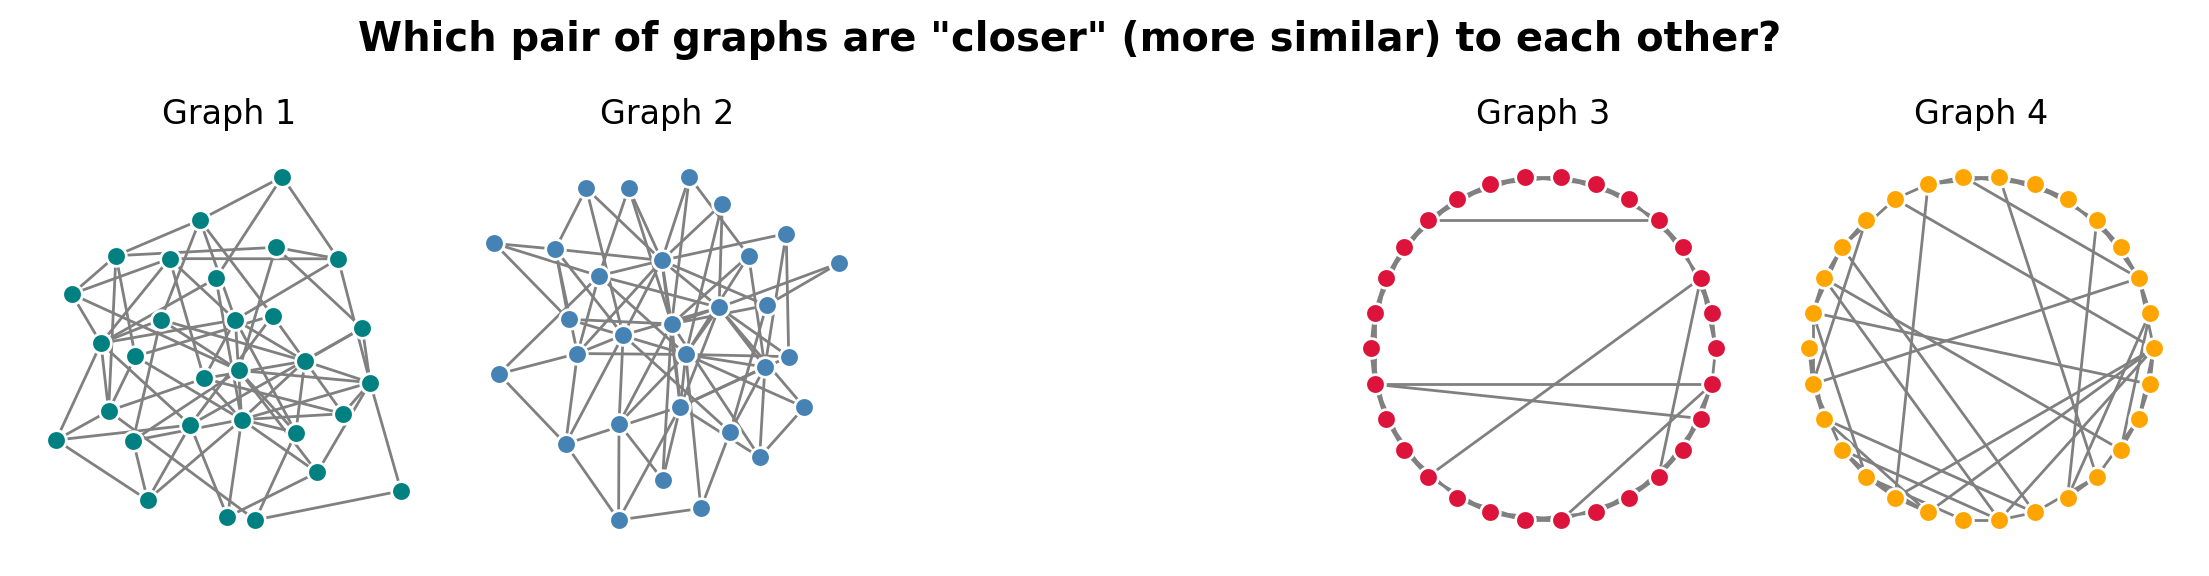

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

N = 30

G1 = nx.erdos_renyi_graph(N, p=0.18)
G2 = nx.barabasi_albert_graph(N, m=3)

G3 = nx.watts_strogatz_graph(N, k=4, p=0.07)
G4 = nx.watts_strogatz_graph(N, k=4, p=0.35)

fig, ax = plt.subplots(1,5,figsize=(14,2.75),dpi=200,
                       gridspec_kw={'width_ratios':[1,1,1,1,1]})
plt.subplots_adjust(wspace=0.05)
ax[0].set_title('Graph 1')
nx.draw_kamada_kawai(G1, node_size=50, edge_color='0.5', node_color='teal',
                     edgecolors='w', ax=ax[0])
ax[1].set_title('Graph 2')
nx.draw_kamada_kawai(G2, node_size=50, edge_color='0.5', node_color='steelblue',
                     edgecolors='w', ax=ax[1])
ax[2].set_axis_off()
ax[3].set_title('Graph 3')
nx.draw_circular(G3, node_size=50, edge_color='0.5', node_color='crimson',
                 edgecolors='w', ax=ax[3])
ax[4].set_title('Graph 4')
nx.draw_circular(G4, node_size=50, edge_color='0.5', node_color='orange',
                 edgecolors='w', ax=ax[4])

plt.suptitle('Which pair of graphs are "closer" (more similar) to each other?', y=1.1,
             fontweight='bold', fontsize='x-large')

plt.show()

___________

Is this even a well-posed question?

![](images/mugs.png)

__________

![](images/simgraphs.png)


________
## What is graph distance?

Networks are complex, high-dimensional objects. Still, many tasks boil down to the question: how similar are two graphs? A graph distance addresses this by mapping a pair of graphs to a nonnegative scalar that encodes their dissimilarity.


In practice, most usable constructions follow a two-stage pipeline:

1. a **descriptor** $\phi$ that extracts features from a graph, and
2. a **distance** $d$ that compares those features.

Formally, for graphs $G_1$ and $G_2$, 

$$D(G_1, G_2) = d(\phi(G_1), \phi(G_2))$$

The concept of graph distance provides a framework to quantify this similarity (or dissimilarity) by defining a function that maps a pair of graphs to a single scalar value, representing their distance.


_________
### What is a descriptor?

A descriptor is a mapping that summarizes a network into a feature (scalar, vector, etc.) that can be compared, modeled, or fed into downstream analyses. Formally, for a space of graphs, $\mathcal{G}$, (nodes, edges, entire graphs, paths, motifs, distributions), a descriptor is a function that maps to a feature space:

$$\phi: \mathcal{G} \rightarrow \mathcal{F}$$ 

where $\mathcal{F}$ might be $\mathbb{R}^k$ (fixed-length vectors), a probability simplex (distributions), a multiset (spectra, motif bags), or a structured space (embeddings, partitions). Good descriptors are (i) isomorphism-invariant, (ii) stable/robust to small perturbations, (iii) discriminative for the task, and (iv) tractable and interpretable.

#### Common descriptors
A descriptor, in practice, can be anything from network size or density to degree sequence/statistics, clustering coefficients, path-length summaries, assortativity/mixing, k-core/coreness distributions, spectral summaries, motif/graphlet counts, label/attribute histograms, and more.

* **NetSimile signature:** a fixed-length vector formed by aggregating node-level features (degree, clustering, egonet stats) with moments such as mean/median/std/skew/kurtosis; distances compare these signature vectors.
* **NetLSD heat-trace curve:** the multi-scale heat signature ($h(t)=\mathrm{tr}(e^{-tL})$) sampled on a grid; distances compare the resulting curves.
* **Network Portrait (for NPD):** a graph-invariant matrix summarizing, for each shortest-path length ($\ell$), the distribution of shell sizes; distances use JS divergence between normalized portraits.
* **DeltaCon affinity matrix:** node-to-node "influence"/affinity matrix derived from a fast belief-propagation linear system; distances compare these matrices (e.g., rooted Euclidean).
* **HIM components:** (i) **edge-presence vector** (local edit signal) and (ii) **Laplacian spectral density** (global geometry); the distance blends both.
* **Graphlet Correlation Matrix (GCD):** Spearman correlations among node-orbit counts for small graphlets; distance is Frobenius between upper-triangles.
* **NetEmd distributions:** shape-aligned distributions of node-level statistics (degree, coreness, centralities), compared with Earth-Mover's/Wasserstein and aggregated.
* **D-measure summaries:** distributions of shortest-path lengths and a centrality distribution combined via information-theoretic divergences.



*Note:* Some have suggested that an ensemble of descriptors makes for the best distance

$$\Phi(G)=[\phi_1(G),\ldots,\phi_m(G)]$$

to capture complementary scales (local ↔ mesoscopic ↔ global) before applying a distance in the next step.
___________

### What is a distance?

A (metric) distance on a set $\mathcal{X}$ is a function

$$\mathcal{X}\times\mathcal{X}\to\mathbb{R}_{\ge 0}$$

satisfying four axioms:

1. **Non-negativity** ($d(x,y)\ge 0$);
2. **Identity of indiscernibles** ($d(x,y)=0\iff x=y$);
3. **Symmetry** ($d(x,y)=d(y,x)$);
4. **Triangle inequality** ($d(x,z)\le d(x,y)+d(y,z)$).

...

However, many graph distance measures:  
- May not strictly satisfy the **triangle inequality**.  
- Can have $d(x, y) = 0$ for $x \neq y$, similar to **pseudometrics**.  

Despite these deviations, the term "graph distance" is widely used to describe dissimilarity measures between graphs, even if they lack some formal metric properties.

<!-- Relaxations and strengthenings appear often: **pseudometrics** (allow ($d(x,y)=0) for (x\neq y)$), **quasi-metrics** (drop symmetry), **semi-metrics** (drop triangle inequality), and **ultrametrics** (strong triangle: ($d(x,z)\le \max{d(x,y),d(y,z)})$).  -->

Deza & Deza’s *Encyclopedia of Distances* is the standard reference for this taxonomy and related notions.

___

Distances (and "distance-like" divergences) are chosen to match the structure of the feature space your descriptor $\phi(G)$ lives in. Some widely used families:

#### Vector spaces (features in ($\mathbb{R}^k)$)

* **$\ell_p$ norms** -- Manhattan $p{=}1$, Euclidean $p{=}2$, Chebyshev $p{=}\infty)$; true metrics.
* **Mahalanobis distance** -- quadratic form with positive-definite matrix); metric if the matrix is PD.
* **Cosine distance** -- using the angle $d(x,y)=\arccos \frac{\langle x,y\rangle}{|x||y|}$ is a metric; the "($1-\text{cosine}$)" variant is not.
* **Frobenius norm** -- for matrix-valued features; equals the $\ell_2$ norm on vectorized entries.


#### Sets, strings, graphs (combinatorial objects)

* **Hamming distance** -- on bit strings/indicator vectors; metric.
* **Edit/Levenshtein distance** -- on strings; graph-edit distance variants extend this idea (may be metric depending on operation costs).
* **Hausdorff distance** -- between subsets of a metric space; a metric on non-empty compact sets.
* **Gromov–Hausdorff distance** -- between (compact) metric spaces; central in comparing shapes/spaces up to isometry.


#### Probability distributions (descriptor is a distribution/measure)

* **Total variation** -- $\tfrac12|P-Q|_1$; metric
* **Wasserstein/Optimal Transport** -- $W_p$; true metric on probability measures with finite $p$-moment, widely used for comparing histograms/signatures.
* **Jensen–Shannon distance** -- square root of JS divergence; a metric, unlike KL divergence.
* **Kullback–Leibler divergence** -- and general $f$-divergences: symmetric versions may still fail the triangle inequality; helpful as *divergences* but not metrics.




#### ...and many more

![](images/common_distances.png)
_____________

![](images/book_of_distances.png)


---

## What to check when choosing a distance

* **Axioms needed?** -- Do you truly need a metric, or is a divergence acceptable for your task (e.g., optimization, information-theoretic comparisons)? Deza & Deza provide a menu of options and implications.
* **Invariance and scaling.** -- Is the distance invariant to relabeling, shifts/scales, or rotations required by your descriptor?
* **Stability/robustness.** -- Does it change smoothly under small perturbations/noise? Wasserstein and JS are often more stable than raw KL or histogram bin-by-bin ($\ell_p$).
* **Computational cost.** -- Optimal transport-based distances can be heavy; entropic regularization and low-rank tricks are common approximations.

This gives you a principled menu: pick your descriptor $\phi(G)$, then select $d$ whose axioms and geometry match $\phi$'s space and your task (retrieval, clustering, change detection, etc.)

____

The best way to choose $\phi$ and $d$ is not straightforward because graphs are complex objects which have lots of properties. The process of devising a graph distance makes inherent assumptions about which properties are *most important* and with which metric they should be compared. As a result many graph distance measures have been proposed. Each method has its strengths and weaknesses and varies in the type of graphs to which it can be applied.
________

### Some caveats

There are two broad categories of problems when it comes to comparing graphs.

Firstly, we may want to compare graphs where the each node in $G_1$ maps on to a node in $G_2$ (**Known Node Correspondence**). For example we may be interested in different types of social interaction that occur between the same set of people, or how the flight patterns between the same set of airports changes over time or between different airlines.

Secondly, we may be interested in comparing graphs where there isn't a precise mapping of nodes between the two graphs (**Unknown Node Correspondence**). For example if we wanted to know how similar are the commuting patterns between Boston and San Diego, or how the interaction structure of different protein complexes compares. Or we may be interested in comparing graphs of different sizes. There are different measures for tackling each of these problems. In general, measures for comparing graphs of unknown node correspondence can also be used for graphs with known node correspondence but not vice versa.

Distance measures also differ in the types of graph they work on. Not all measures will work on directed or weighted graphs.

______________

## Why do we care?

Graph distance measures are important in a range of applications, such as:

- **Graph classification**: Grouping graphs into categories based on their similarity (e.g., diagnosing conditions based on brain connectomes).
- **Network evolution**: Tracking how a network changes over time and identifying anomalies or change points (e.g., comparing the structure of a social network at different time points).
- **Node alignment**: Graph distances can help evaluate how well a proposed alignment preserves structural or functional similarity between nodes. Some alignment methods, such as graph matching or network embedding techniques, rely on graph distance measures to iteratively optimize node mappings.
- **Model evaluation**: Quantifying how well a generative model replicates real-world networks.
- **Hypothesis resting**: Comparing the structures of two networks to test a hypothesis (e.g., testing whether two biological networks share similar functional modules).
- **Typicality**: Graph distances can help us understand how representative a given graph is to a given graph ensemble .

And moving towards a better understanding of the fundamentals of networks!

---

## Example Distance Measures

### 1. Jaccard

The **Jaccard distance** between two graphs compares the *overlap of their edge sets*.

#### Definition (set form)

Let $G_1=(V,E_1)$ and $G_2=(V,E_2)$ share the same labeled node set $V$ (i.e., **known node correspondence**). Then


$$D_{\text{Jacc}}(G_1,G_2) = 1-\frac{|E_1\cap E_2|}{|E_1\cup E_2|}$$


By convention, if $E_1\cup E_2=\varnothing$ (both edgeless), set $D_{\text{Jacc}}(G_1,G_2)=0$.

* Requires: same node set and labeling.
* Classic form: undirected, unweighted, no self-loops.
* Interprets distance as "fraction of *disagreeing* edges" among all edges that appear in at least one graph.



#### Matrix form (simple, undirected graphs)

Let $A_1,A_2\in{0,1}^{n\times n}$ be symmetric, hollow adjacency matrices (simple undirected graphs). Define the upper-triangle index set

$$\mathcal{U}={(i,j),:,1\le i<j\le n}$$

Then

$$ S=\sum_{(i,j)\in\mathcal{U}} (A_1)*{ij}(A_2)*{ij}$$

$$ T=\sum_{(i,j)\in\mathcal{U}} \mathbf{1} \left( (A_1)*{ij}=1\ \lor\ (A_2)*{ij}=1 \right) $$

and

$$ D_{\text{Jacc}}(G_1,G_2)=
\begin{cases}
0, & T=0,\\
1-\dfrac{S}{T}, & T>0.
\end{cases}
$$

<!-- Equivalently, using elementwise operators (Hadamard $\odot$, max $\vee$ and the $\ell_1$ norm) on the upper triangle,

$$ S=\big| (A_1\odot A_2)*{\mathcal{U}}\big|*{1} $$

$$ T=\big| (A_1\vee A_2)*{\mathcal{U}}\big|*{1} $$

 -->
*Note:* Restricting to $\mathcal{U}$ avoids double-counting undirected edges. For directed graphs, drop the symmetry/hollow assumptions and sum over all $i\neq j$.

In [2]:
def jaccard_distance(G1, G2):
    """
    Calculates the Jaccard distance between two graphs.
    The Jaccard distance is defined as 1 minus the ratio of the size of the intersection 
    of the edge sets to the size of the union of the edge sets.

    Parameters:
    G1 (networkx.Graph): The first graph.
    G2 (networkx.Graph): The second graph.
    Returns:
    float: The Jaccard distance between the two graphs.
    """

    a_1 = nx.to_numpy_array(G1) # convert G1 to adjacency matrix
    a_2 = nx.to_numpy_array(G2) # convert G2 to adjacency matrix

    s_12 = a_1*a_2 # intersection of edges in a_1 and a_2
    t_12 = s_12 + (1-a_2)*a_1 + (1-a_1)*a_2 # union of edges in a_1 and a_2

    S = np.sum(s_12) # total number of edges in intersection
    T = np.sum(t_12) # total number of edges in union

    return 1 - S/T

#### What properties might a distance measure have?
We can probably think of some properties that we might like a distance measure to have. These are all arguable to some extent, but some such properties are

1. **Identity property**: the distance between the same graph (or two isomorphic graphs) should be 0 ie. $D(G_1, G_1) = 0$. 

2. **Zero property**: given $G$ and $G'$ where $G'$ contains all the edges which $G$ does not contain, we might expect that $D(G,G')$ is maximal.


In [3]:
import random
random.seed(0)
np.random.seed(0)

# Identity and complement
G = nx.gnp_random_graph(1000, 0.05, seed=1)
d = jaccard_distance(G, G)
print(f"D(G, G) = {d:.2f}")  # expect 0.00

G_comp = nx.complement(G)
d_comp = jaccard_distance(G, G_comp)
print(f"D(G, G') = {d_comp:.2f}")  # expect 1.00 (or very close if self-loops were present, but we excluded them)


D(G, G) = 0.00
D(G, G') = 1.00


3. **Symmetry property**: we might expect that $D(G_1, G_2) = D(G_2, G_1)$

In [4]:
# Symmetry
G1 = nx.watts_strogatz_graph(100, 4, 0.1, seed=1)
G2 = nx.watts_strogatz_graph(100, 4, 0.2, seed=2)
d12 = jaccard_distance(G1, G2)
d21 = jaccard_distance(G2, G1)
print(f"D(G1, G2) = {d12:.5f}, D(G2, G1) = {d21:.5f}")  # equal

D(G1, G2) = 0.40637, D(G2, G1) = 0.40637


4. **Sensitivity to perturbation**: If we perturb a graph $G$ slightly (eg adding/removing edges) resulting in $G'$ we might expect $D(G, G')$ to start off close to 0 and grow as the perturbation increases.

In [5]:
import random 

# Helper functions for perturbations
def remove_random_edge(G):
    if G.number_of_edges() == 0: 
        return
    u, v = random.choice(list(G.edges()))
    G.remove_edge(u, v)

def add_random_edge(G):
    if G.number_of_edges() == G.number_of_nodes()*(G.number_of_nodes()-1)//2:
        return  # already complete
    nodes = list(G.nodes())
    while True:
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)
            return

def rewire_random_edge(G):
    if G.number_of_edges() == 0:
        return
    u, v = random.choice(list(G.edges()))
    G.remove_edge(u, v)
    add_random_edge(G)

def rewire_preserve_degree(G):
    # one successful swap (if possible)
    try:
        nx.double_edge_swap(G, nswap=1, max_tries=1000)
    except nx.NetworkXError:
        pass

def perturb_and_measure(base_graph, perturbation_func, distance_func, iterations=100):
    H = base_graph.copy()
    dists = [distance_func(base_graph, H)]
    for _ in range(iterations):
        perturbation_func(H)
        dists.append(distance_func(base_graph, H))
    return dists


In [6]:
# Initialize graphs
er = nx.gnp_random_graph(1000, 0.02)
ba = nx.barabasi_albert_graph(1000, 3)
ws = nx.watts_strogatz_graph(1000, 10, 0.02)

# Define distance metric
distance_func = jaccard_distance

# Define perturbation experiments
perturbations = {
    "remove_edge": remove_random_edge,
    "add_edge": add_random_edge,
    "rewire_edge": rewire_random_edge,
    "rewire_preserve_degree": rewire_preserve_degree
}

# Run experiments
results = {}
iterations = 100

for perturbation_name, perturbation_func in perturbations.items():
    results[f"er_{perturbation_name}"] = perturb_and_measure(er, perturbation_func, distance_func, iterations)
    results[f"ba_{perturbation_name}"] = perturb_and_measure(ba, perturbation_func, distance_func, iterations)
    results[f"ws_{perturbation_name}"] = perturb_and_measure(ws, perturbation_func, distance_func, iterations)


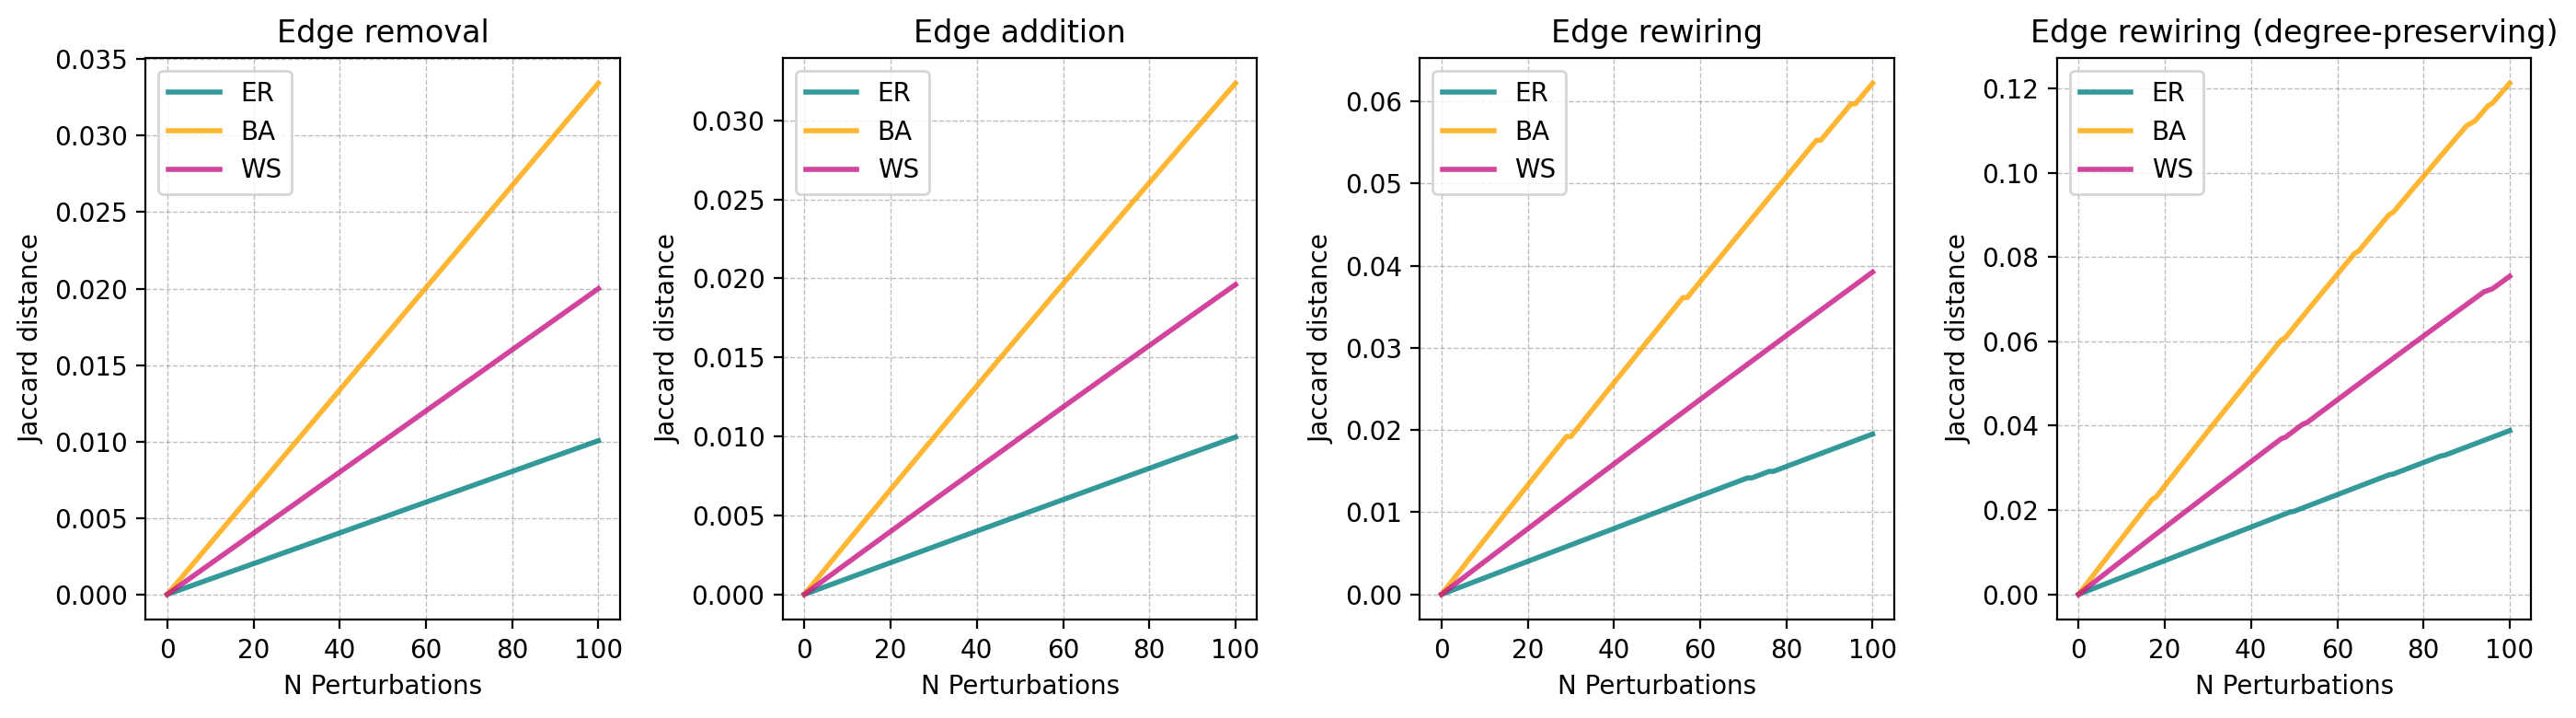

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(14, 4), dpi=200)
plt.subplots_adjust(wspace=0.5)

# Define colors and labels
colors = {'ER': 'teal', 'BA': 'orange', 'WS': 'mediumvioletred'}
graphs = ['er', 'ba', 'ws']

# Plot each perturbation type
perturbation_types = ['remove_edge', 'add_edge', 'rewire_edge', 'rewire_preserve_degree']
titles = ['Edge removal', 'Edge addition', 'Edge rewiring', 'Edge rewiring (degree-preserving)']

for i, perturbation in enumerate(perturbation_types):
    for graph in graphs:
        label = graph.upper()
        ax[i].plot(results[f"{graph}_{perturbation}"], color=colors[label],
                   alpha=0.8, label=label, lw=2)
    
    # Formatting each subplot
    ax[i].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('N Perturbations')
    ax[i].set_ylabel('Jaccard distance')
    ax[i].legend()

# Show the plot
plt.tight_layout()
plt.show()

5. **Irrelevance of random differences**: If we perturb a graph $G$ by randomizing edges resulting in $G'$, we might expect the distance $D(G, G')$ to asymptote as the graph becomes fully randomized.

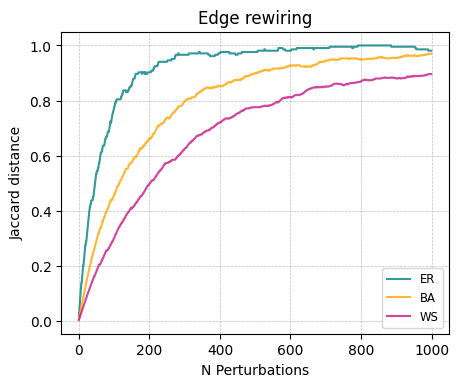

In [8]:
# Initialize graphs
er = nx.gnp_random_graph(100, 0.02)
ba = nx.barabasi_albert_graph(100, 3)
ws = nx.watts_strogatz_graph(100, 10, 0.02)

# Initialize distance lists
d_er_rewire = []
d_ba_rewire = []
d_ws_rewire = []

g_er = er.copy()
g_ba = ba.copy()
g_ws = ws.copy()

# Perform perturbations
iterations = 1000
for i in range(iterations):
    # Randomly choose a perturbation type for each graph
    rewire_random_edge(g_er)
    d_er_rewire.append(distance_func(er, g_er))

    rewire_random_edge(g_ba)
    d_ba_rewire.append(distance_func(ba, g_ba))

    rewire_random_edge(g_ws)
    d_ws_rewire.append(distance_func(ws, g_ws))
    
    
fig, ax = plt.subplots(1,1, figsize=(5,4), dpi=100)

ax.plot(d_er_rewire, color = 'teal', alpha = 0.8, label = 'ER')
ax.plot(d_ba_rewire, color = 'orange', alpha = 0.8, label = 'BA')
ax.plot(d_ws_rewire, color = 'mediumvioletred', alpha = 0.8, label = 'WS')

ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5, alpha = 0.5)

ax.set_title('Edge rewiring')
ax.set_xlabel('N Perturbations')
ax.set_ylabel('Jaccard distance')

ax.legend(fontsize = 'small')

plt.show()

## Your turn! 4 minute challenge (no code yet)

In pairs: What's a property of a network that would be a useful *descriptor* to use in a graph distance?

In [9]:
pass

____________

## Your turn! 3 minute challenge (no code yet)

In pairs: **How would we *know*** that it is a useful property?

In [10]:
pass

______________

In [11]:
pass

__________
## Introduction to NetRD!

**NetRD** is an open-source Python library that brings together two things network scientists often need in one place: (i) graph distances (dozens of ways to compare networks) and (ii) network reconstruction methods (inferring networks from multivariate time series), plus utilities for simulating dynamics—all with a consistent, NetworkX-friendly API.

* It implements many canonical graph distances (e.g., Hamming-Ipsen-Mikhailov, DeltaCon, NetSimile, Portrait Divergence, NetLSD), so you can test descriptor+distance choices without recoding them.
* It’s designed for side-by-side evaluation, perfect for exercises like WEGD comparisons and perturbation tests.

**Reference paper:** McCabe *et al.* "netrd: A library for network reconstruction and graph distances," JOSS (2021) / arXiv (2020).

In short: if you want to try multiple graph distances quickly, or reconstruct networks from time series and then compare them, NetRD gives you a clean, well-documented toolbox that fits naturally with NetworkX workflows.

In [12]:
import netrd
g1 = nx.watts_strogatz_graph(200, 4, 0.1)
g2 = nx.watts_strogatz_graph(200, 4, 0.2)
jd = netrd.distance.JaccardDistance()
jd.dist(g1, g2)

0.42829076620825146

In [13]:
jaccard_distance(g1, g2)

0.42829076620825146

### Degree Jensen-Shannon Divergence 

Degree Jensen-Shannon Divergence compares the the degree distributions of two graphs. For a graph of $n$ nodes, the descriptor is the degree distribution $\mathbf{p} = p_k(G) = \frac{n_k(G)}{n}$ where $n_k(G)$ is the number of nodes of degree $k$ in the graph. The distance between two degree distributions $\mathbf{p_1}$ and $\mathbf{p_2}$ then calculated as 

$$ D(G_1, G_2) = H[\mathbf{p_+}] - \frac{1}{2} (H[\mathbf{p_1}] + H[\mathbf{p_2}])$$

where
- $\mathbf{p_+} = \frac{\mathbf{p_1} + \mathbf{p_2}}{2}$ is the **mixture distribution**, representing the average of the two degree distributions.
- $H[\mathbf{p}] = - \sum_k p_k \ln p_k$ is the Shannon entropy of a degree distribution, which quantifies the uncertainty or disorder of the distribution. 

**Entropy** is a measure of the uncertainty or diversity in a distribution. In the context of degree sequences, entropy quantifies the unpredictability of a node's degree in a graph. If the degree distribution is highly heterogeneous the entropy will be higher because the degree of nodes is less predictable. On the other hand, if the degree distribution is more homogeneous (i.e., nodes have similar degrees), the entropy will be lower because the degree of a node is more predictable.

One key advantage of Degreee JSD over the Jaccard distance is that it works on networks with **unknown node correspondence**.

In [14]:
from collections import Counter
def jensen_shannon_divergence(g1, g2):
    def ordered_degree_counts(g):
        """Given a graph, return an ordered, normalized list of degree counts."""
        degrees = [g.degree(n) for n in g.nodes()]
        degree_counts = Counter(degrees)
        degree_counts_ordered = [degree_counts[v] for v in range(max(degrees) + 1)]
        total_nodes = sum(degree_counts_ordered)
        return [count / total_nodes for count in degree_counts_ordered]  # Normalize

    def entropy(p):
        """Calculate the entropy of a probability distribution."""
        return -sum(pk * np.log2(pk) for pk in p if pk != 0)

    # Get normalized degree distributions
    p1 = ordered_degree_counts(g1)
    p2 = ordered_degree_counts(g2)

    # Pad distributions to the same length
    max_len = max(len(p1), len(p2))
    p1.extend([0] * (max_len - len(p1)))
    p2.extend([0] * (max_len - len(p2)))

    # Calculate the intermediate distribution and JS divergence
    p_plus = [(p1k + p2k) / 2 for p1k, p2k in zip(p1, p2)]
    D = entropy(p_plus) - 0.5 * (entropy(p1) + entropy(p2))

    return D


In [15]:
g1 = nx.gnp_random_graph(1000, 0.05)
g2 = nx.gnp_random_graph(1000, 0.05)

jensen_shannon_divergence(g1, nx.complement(g1))

0.9999999999999956

In [16]:
jensen_shannon_divergence(g1,g1)

0.0

In [17]:
# Generalized perturbation function
def perturb_and_measure(base_graph, perturbation_func, distance_func, iterations=100):
    """
    Applies a perturbation function to a copy of the base graph and measures distances.
    
    Parameters:
        base_graph: The original graph.
        perturbation_func: The function to perturb the graph.
        distance_func: The function to compute distance between graphs.
        iterations: Number of perturbation steps.
        
    Returns:
        List of distances after each perturbation.
    """
    perturbed_graph = base_graph.copy()
    distances = [distance_func(base_graph, perturbed_graph)]  # Initial distance
    for _ in range(iterations):
        perturbation_func(perturbed_graph)
        distances.append(distance_func(base_graph, perturbed_graph))
    return distances

# Initialize graphs
er = nx.gnp_random_graph(1000, 0.02)
ba = nx.barabasi_albert_graph(1000, 3)
ws = nx.watts_strogatz_graph(1000, 10, 0.02)

# Define distance metric
distance_func = jensen_shannon_divergence

# Define perturbation experiments
perturbations = {
    "remove_edge": remove_random_edge,
    "add_edge": add_random_edge,
    "rewire_edge": rewire_random_edge,
    "rewire_preserve_degree": rewire_preserve_degree
}

# Run experiments
results = {}
iterations = 100

for perturbation_name, perturbation_func in perturbations.items():
    results[f"er_{perturbation_name}"] = perturb_and_measure(er, perturbation_func, distance_func, iterations)
    results[f"ba_{perturbation_name}"] = perturb_and_measure(ba, perturbation_func, distance_func, iterations)
    results[f"ws_{perturbation_name}"] = perturb_and_measure(ws, perturbation_func, distance_func, iterations)

# Access results as needed, e.g.:
# print(results["er_remove_edge"])


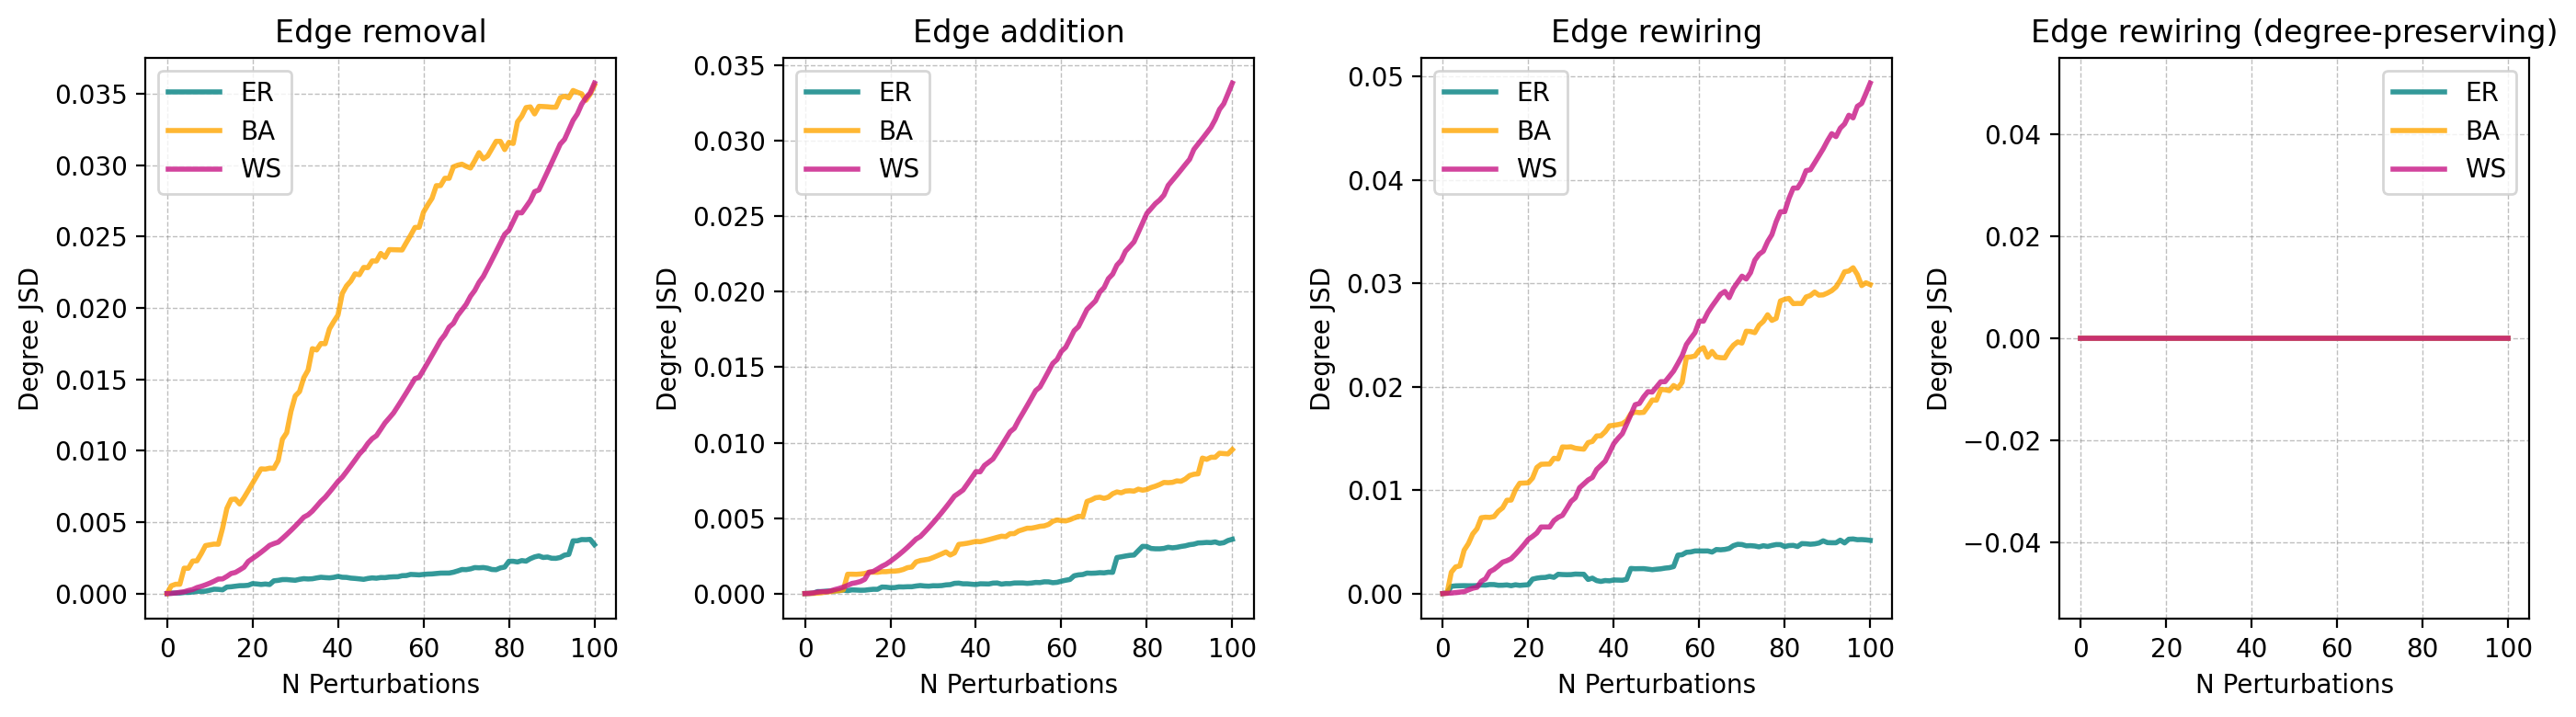

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(14, 4), dpi=200)
plt.subplots_adjust(wspace=0.5)

# Define colors and labels
colors = {'ER': 'teal', 'BA': 'orange', 'WS': 'mediumvioletred'}
graphs = ['er', 'ba', 'ws']

# Plot each perturbation type
perturbation_types = ['remove_edge', 'add_edge', 'rewire_edge', 'rewire_preserve_degree']
titles = ['Edge removal', 'Edge addition', 'Edge rewiring', 'Edge rewiring (degree-preserving)']

for i, perturbation in enumerate(perturbation_types):
    for graph in graphs:
        label = graph.upper()
        ax[i].plot(results[f"{graph}_{perturbation}"], color=colors[label],
                   alpha=0.8, label=label, lw=2)
    
    # Formatting each subplot
    ax[i].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('N Perturbations')
    ax[i].set_ylabel('Degree JSD')
    ax[i].legend()

# Show the plot
plt.tight_layout()
plt.show()

#### Why stop with the degree distribution? 
While differences in the degree distribution capture important differences between networks, theres many network properties and distributions that are also important. In theory we could add more and more such properties into our descriptor when constructing a graph distance measure. This is exactly what **NetSimile** does. NetSimile first constructs a 7x5 feature matrix which contains the median, mean, standard deviation, skewness and kurtosis of the degree distribution, clustering coefficient distribution, two-hop neighbor distribution, average clustering coefficient, and three features about node $i$'s egonet. You can read more about it here:

- Berlingerio, M., Koutra, D., Eliassi-Rad, T., Faloutsos, C., 2012. NetSimile: A Scalable Approach to Size-Independent Network Similarity. https://doi.org/10.48550/ARXIV.1209.2684
    - But why stop here... ($dk$-series distance?)

_____________

## Your turn! (Now with code.)

For 10 minutes, choose a network property that is interesting to you, or multiple properties, and construct a distance measure using them. Test if your distance measure satisfies the properties mentioned above (symmetry, zero, identity) and perform one of the perturbation tests using your distance measure.

    Tip: keep node correspondence in mind. Many distances assume the same labeled node set.

In [19]:
# ======================
# 1) DESCRIPTOR (FILL IN)
# ======================
def descriptor(G, params=None):
    """
    Compute a graph descriptor to use in a distance calculation.

    Parameters
    ----------
    G : networkx.Graph
        Input graph (assume simple, undirected unless you state otherwise).
    params : dict | None
        Hyperparameters for your descriptor (e.g., {'bins': 20}, {'k': 10}).


    Returns
    -------
    descriptor : array-like

    """
    
    
    pass


# =====================
# 2) DISTANCE (FILL IN)
# =====================
def distance_measure(G1, G2, descriptor_params=None, distance_params=None):
    """
    Compute a distance between two graphs via (descriptor -> distance).

    Pipeline:
    1) Compute phi(G1) and phi(G2) using `descriptor(...)`.
    2) Compare phi(G1) and phi(G2) using a distance on the descriptor space.

    Parameters
    ----------
    G1, G2 : nx.Graph
        Graphs to compare (state your assumptions: same node set? directed? weighted?).
    descriptor_params : dict | None
        Hyperparameters for the descriptor computation.
    distance_params : dict | None
        Hyperparameters for the distance (e.g., {"p": 2} for L2).

    Returns
    -------
    float
        A nonnegative scalar. Decide if 0 means identical descriptors.

    """

    
    pass

___________
## Graph distance evaluation: The within-ensemble graph distance (WEGD)

A distance can satisfy more *informal* criteria, which ends up being quite helpful in practice. We need a way to calibrate a distance against the variability of graphs that "should" look the same, and to see how it reacts around known network properties that we care about.

> Hartle, H., Klein, B., McCabe, S., Daniels, A., St-Onge, G., Murphy, C., Hébert-Dufresne, L., 2020. Network comparison and the within-ensemble graph distance. Proc. R. Soc. A. 476, 20190744. https://doi.org/10.1098/rspa.2019.0744

### Defintion

Given a random graph ensemble $\mathcal{E}(\theta)$ (e.g., $G(n,p)$, WS$(n,k,\beta)$, SBM($\theta$), nonlinear preferential attachment with exponent $\alpha$, etc.) and a distance $D$, the **within-ensemble graph distance** at parameter setting $\theta$ is the *expected* distance between two independent graphs drawn from the *same ensemble with the same parameterization*:

$$\mathrm{WEGD}_D(\theta) = \mathbb{E} \left[ D(G,G') ,\middle|, G,G' \stackrel{\text{i.i.d.}}{\sim} \mathcal{E}(\theta) \right]$$


In words: WEGD is the average dissimilarity you get just from *randomness of the generator*, not from changing the mechanism or its parameters. It is your noise floor for $D$ at $\theta$.

#### Monte Carlo estimate

Given $m$ i.i.d. samples $G_1,\dots,G_m \sim \mathcal{E}(\theta)$, estimate

$$\widehat{\mathrm{WEGD}}_D(\theta) = \frac{2}{m(m-1)} \sum_{1\le i<j\le m} D(G_i, G_j)$$

This averages $D$ over all unordered pairs at the same $\theta$.

_________

### Notes and assumptions

* **Same parameterization:** Graphs compared in WEGD *must* share the same $\theta$ (and, if required by $D$, the same labeled node set).
* **Descriptor dependence:** WEGD depends on your chosen descriptor and the induced distance; a descriptor that ignores mesoscopic structure may yield a low WEGD even where the ensemble varies meaningfully.
* **Critical points:** Sweeping $\theta$ across known transitions (e.g., $np=1$ in $G(n,p)$; $\alpha\approx 1$ in nonlinear PA) often produces characteristic rises in $\widehat{\mathrm{WEGD}}_D(\theta)$, revealing where the ensemble becomes intrinsically more variable under $D$.
* **Use:** Compare WEGD to a between-ensemble average to judge separability; a good $D$ keeps WEGD small away from critical points and grows in a controlled way near them.


### Why ensembles (and their critical points)?

Classic models have **known structural transitions**, so they make natural stress tests:

* **Erdős-Rényi** ($G(n,p)$): giant component emergence at $\langle k\rangle = np = 1$; connectivity near $\langle k\rangle \approx \log n$.
* **Nonlinear preferential attachment** (exponent $\alpha$): qualitative regime changes around $\alpha = 1$ (linear PA), ($\alpha>1$) (condensation), with further structure shifts near other landmarks (e.g., $\alpha \approx 2$).
* **Watts-Strogatz** (rewiring $\beta$): rapid drop in path length as shortcuts appear, with clustering decaying more slowly.
* **SBM**: detectability thresholds as signal-to-noise crosses known bounds.

**What to look for.** Sweep $\theta$ across these landmarks and track $\widehat{\mathrm{WEGD}}_D(\theta)$.

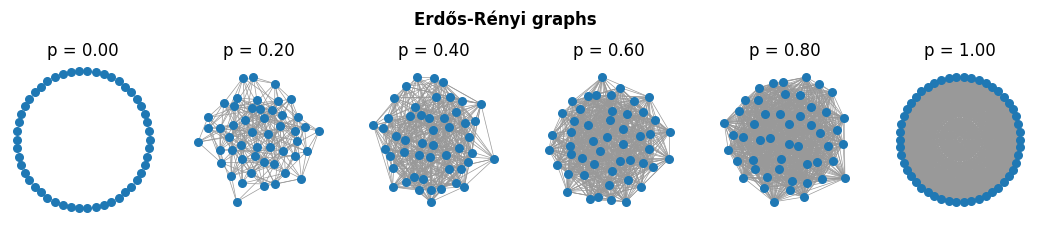

In [20]:
### Example WEGD #1

N = 50
p_vals = np.linspace(0,1,51)

######
p_vals_plot = np.linspace(0,1,6)

fig, ax = plt.subplots(1, len(p_vals_plot), figsize=(2.2*len(p_vals_plot),2), dpi=100)

for ix, p in enumerate(p_vals_plot):
    G = nx.erdos_renyi_graph(N,p)
    nx.draw_kamada_kawai(G, ax=ax[ix], node_size=30, edge_color='.6', width=0.5)
    ax[ix].set_title('p = %.2f'%p)


plt.suptitle('Erdős-Rényi graphs', y=1.15, fontweight='bold')

plt.show()

In [21]:
d1 = netrd.distance.DegreeDivergence()

In [22]:
### WEGD
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

n_iter = 40
dists_out1 = {p:[] for p in p_vals}

for p in p_vals:
    for _ in range(n_iter):
        G1 = nx.erdos_renyi_graph(N, p)
        G2 = nx.erdos_renyi_graph(N, p)
    
        d_i = d1.dist(G1, G2)
        dists_out1[p].append(np.nan_to_num(d_i))

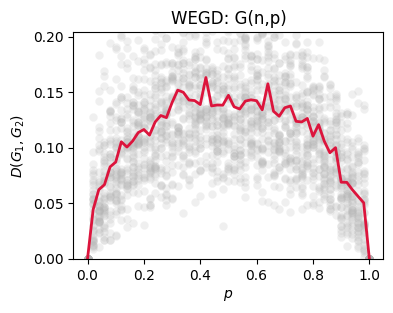

In [23]:
fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=100)

for p in p_vals:
    ax.scatter([p]*len(dists_out1[p]), dists_out1[p],
               color='.7', alpha=0.2, lw=0)

means1 = [np.nanmean(i) for i in dists_out1.values()]
ax.plot(list(dists_out1.keys()), means1,
        color='crimson', lw=2)

ax.set_xlabel('$p$')
ax.set_ylabel('$D(G_1, G_2)$')

ax.set_title('WEGD: G(n,p)')
ax.set_ylim(0, max(means1)*1.25)

plt.show()

In [24]:
def preferential_attachment_network(N, alpha=1.0, m=1):
    r"""
    Generates a network based off of a preferential attachment growth rule.
    Under this growth rule, new nodes place their $m$ edges to nodes already
    present in the graph, G, with a probability proportional to $k^\alpha$.

    Parameters
    ----------
    N (int): the desired number of nodes in the final network
    alpha (float): the exponent of preferential attachment. When alpha is less
                   than 1.0, we describe it as sublinear preferential
                   attachment. At alpha > 1.0, it is superlinear preferential
                   attachment. And at alpha=1.0, the network was grown under
                   linear preferential attachment, as in the case of
                   Barabasi-Albert networks.
    m (int): the number of new links that each new node joins the network with.

    Returns
    -------
    G (nx.Graph): a graph grown under preferential attachment.

    """

    G = nx.Graph()
    G = nx.complete_graph(m+1)

    for node_i in range(m+1, N):
        degrees = np.array(list(dict(G.degree()).values()))
        probs = (degrees**alpha) / sum(degrees**alpha)
        eijs = np.random.choice(
                    G.number_of_nodes(), size=(m,),
                    replace=False, p=probs)
        for node_j in eijs:
            G.add_edge(node_i, node_j)

    return G

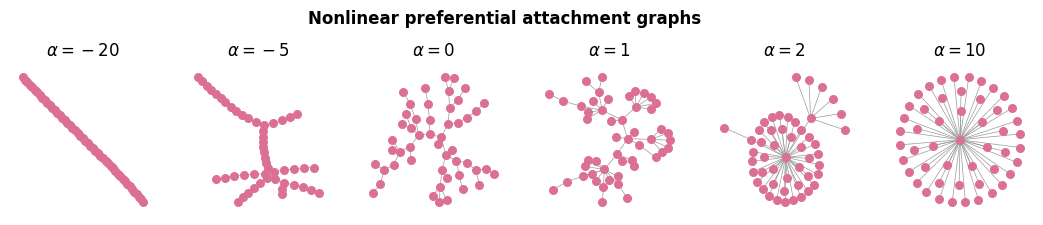

In [25]:
### Example WEGD #2

N = 50
a_vals = np.linspace(-10,10,61)

######
a_vals_plot = [-20, -5, 0, 1, 2, 10]

fig, ax = plt.subplots(1, len(a_vals_plot), figsize=(2.2*len(p_vals_plot),2), dpi=100)

for ix, a in enumerate(a_vals_plot):
    G = preferential_attachment_network(N, float(a), m=1)
    nx.draw_kamada_kawai(G, ax=ax[ix], node_size=30, edge_color='.6', width=0.5, node_color='palevioletred')
    ax[ix].set_title(r'$\alpha = %.0f$'%a)


plt.suptitle('Nonlinear preferential attachment graphs', y=1.15, fontweight='bold')

plt.show()

In [26]:
d2 = netrd.distance.DMeasure()

In [27]:
### WEGD

n_iter = 40
dists_out2 = {a:[] for a in a_vals}

for a in a_vals:
    for _ in range(n_iter):
        G1 = preferential_attachment_network(N, float(a), m=1)
        G2 = preferential_attachment_network(N, float(a), m=1)
    
        d_i = d2.dist(G1, G2)
        dists_out2[a].append(np.nan_to_num(d_i))

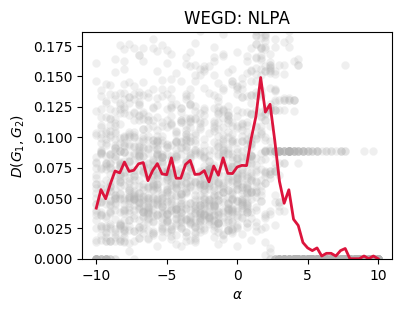

In [28]:
fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=100)

for a in a_vals:
    ax.scatter([a]*len(dists_out2[a]), dists_out2[a],
               color='.7', alpha=0.2, lw=0)
    

means2 = [np.mean(i) for i in dists_out2.values()]
ax.plot(list(dists_out2.keys()), means2,
        color='crimson', lw=2)

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$D(G_1, G_2)$')

ax.set_title('WEGD: NLPA')
ax.set_ylim(0, max(means2)*1.25)


plt.show()

_________
![](images/wegd_er.png)

![](images/wegd_table.png)

__________
## Next time...
Dynamics of Networks: Temporal Networks `class_20_temporal_networks.ipynb`
_______

## References and further resources:

1. Hartle, H., Klein, B., McCabe, S., Daniels, A., St-Onge, G., Murphy, C., Hébert-Dufresne, L., 2020. Network comparison and the within-ensemble graph distance. Proc. R. Soc. A. 476, 20190744. https://doi.org/10.1098/rspa.2019.0744
2. Soundarajan, S., Eliassi-Rad, T., Gallagher, B., 2014. A Guide to Selecting a Network Similarity Method, in: Proceedings of the 2014 SIAM International Conference on Data Mining. Presented at the Proceedings of the 2014 SIAM International Conference on Data Mining, Society for Industrial and Applied Mathematics, pp. 1037–1045. https://doi.org/10.1137/1.9781611973440.118
3. Tantardini, M., Ieva, F., Tajoli, L., Piccardi, C., 2019. Comparing methods for comparing networks. Sci Rep 9, 17557. https://doi.org/10.1038/s41598-019-53708-y
4. Wills, P., Meyer, F.G., 2020. Metrics for graph comparison: A practitioner’s guide. PLoS ONE 15, e0228728. https://doi.org/10.1371/journal.pone.0228728
5. Koutra, D., Vogelstein, J.T., Faloutsos, C., 2013. DeltaCon : A Principled Massive-Graph Similarity Function, in: Proceedings of the 2013 SIAM International Conference on Data Mining. Presented at the Proceedings of the 2013 SIAM International Conference on Data Mining, Society for Industrial and Applied Mathematics, pp. 162–170. https://doi.org/10.1137/1.9781611972832.18
6. Koutra, D., Shah, N., Vogelstein, J.T., Gallagher, B., Faloutsos, C., 2016. DeltaCon: Principled Massive-Graph Similarity Function with Attribution. ACM Trans. Knowl. Discov. Data 10, 1–43. https://doi.org/10.1145/2824443
7. Berlingerio, M., Koutra, D., Eliassi-Rad, T., Faloutsos, C., 2012. NetSimile: A Scalable Approach to Size-Independent Network Similarity. https://doi.org/10.48550/ARXIV.1209.2684
7. McCabe, S., Torres, L., LaRock, T., Haque, S., Yang, C.-H., Hartle, H., Klein, B., 2021. netrd: A library for network reconstruction and graph distances. JOSS 6, 2990. https://doi.org/10.21105/joss.02990
8. Tsitsulin, A., Mottin, D., Karras, P., Bronstein, A., & Müller, E. (2018, July). Netlsd: hearing the shape of a graph. In Proceedings of the 24th ACM SIGKDD international conference on knowledge discovery & data mining (pp. 2347-2356). https://arxiv.org/pdf/1805.10712
9. Bagrow, J.P., & Bollt, E. M. (2019). An information-theoretic, all-scales approach to comparing networks. Applied Network Science, 4(1), 1-15. https://appliednetsci.springeropen.com/articles/10.1007/s41109-019-0156-x
10. Schieber, T. A., Carpi, L., Díaz-Guilera, A., Pardalos, P. M., Masoller, C., & Ravetti, M. G. (2017). Quantification of network structural dissimilarities. Nature communications, 8(1), 13928. https://www.nature.com/articles/ncomms13928
11. [netrd package](https://github.com/netsiphd/netrd/)
12. [NetComp package](https://github.com/peterewills/NetComp/tree/master)